# NLP from Zero to Bert:-
This is a all in one notebook if you're new to Nlp or this competition this is your stop, In this notebook i'll apply from a very basic Lstm model and then gradually move to Google's Bert.
So this is your one spot for learning, fasten your seatbelt and let's begin our journey

***PLease hit an upvote, this notebook has taken days of work to put it all in one place please upvote it so that I keep creating such Notebooks***

PS- Some outputs very lengthy so they are hidden please expand for better understanding

# Content of the Notebook:-
1. Data Cleaning
2. Lstm
3. Bidirectional lstm
4. GRU
5. Attention Model
6. Prepration of dataset for Bert transformer
7. Bert Transformer

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert-base-uncased/vocab.txt
/kaggle/input/bert-base-uncased/config.json
/kaggle/input/bert-base-uncased/pytorch_model.bin
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


Importing necessary Libraries...

In [2]:
import keras
import nltk
import re
import string

In [3]:
from keras.preprocessing.text import one_hot
from keras.layers import LSTM,Embedding,Dense,Bidirectional,GlobalMaxPool2D,BatchNormalization,Dropout,TimeDistributed,GlobalMaxPool1D
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,Model
from keras.layers import SpatialDropout1D,GRU
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

Importing data

In [4]:
train= pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv("../input/nlp-getting-started/test.csv")

In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
ntrain= train.shape[0]
ntest= test.shape[0]

In [7]:
ntrain,ntest

(7613, 3263)

In [8]:
label= train['target']

In [9]:
train.drop(['target'],axis=1,inplace=True)

Here I am concating data, to apply cleaning on both train and test set

In [10]:
data= pd.concat([train,test])

In [11]:
data.shape,train.shape,test.shape

((10876, 4), (7613, 4), (3263, 4))

# Cleaning data:
I would advise you to follow these steps as it, if you have better ideas please let me know

In [12]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [13]:
# Applying the cleaning function to both test and training datasets
data['text'] = data['text'].apply(lambda x: clean_text(x))

function to remove emoji

In [14]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [15]:
data['text']=data['text'].apply(lambda x: remove_emoji(x))

To expand abbreviations

In [16]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)

expand_contractions("can't stop won't stop")

'cannot stop will not stop'

In [17]:
data['text'] =data['text'].apply(expand_contractions)

In [18]:
data['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [19]:
test= data[ntrain:]

In [20]:
train= data[:ntrain]

In [21]:
train.shape,test.shape

((7613, 4), (3263, 4))

In [22]:
tweets= train['text'].copy()

In [23]:
tweets_test= test['text'].copy()

# tokenization

In [25]:

from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(tweets)
vocab_size_train = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(tweets)
# pad documents to a max length of 4 words
max_length = 50
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [26]:
tweets= padded_docs

In [27]:
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(tweets_test)
vocab_size_tesr = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(tweets_test)
# pad documents to a max length of 4 words
max_length = 50
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')


In [28]:
tweets_test= padded_docs

# Word Embedding 
A word embedding is a learned representation for text where words that have the same meaning have a similar representation.

Word embeddings are in fact a class of techniques where individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network, and hence the technique is often lumped into the field of deep learning.

Key to the approach is the idea of using a dense distributed representation for each word.

The distributed representation is learned based on the usage of words. This allows words that are used in similar ways to result in having similar representations, naturally capturing their meaning
https://machinelearningmastery.com/what-are-word-embeddings/#:~:text=A%20word%20embedding%20is%20a,challenging%20natural%20language%20processing%20problems.

Importing GLOVE's word 
To learn more-
https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/

In [29]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('../input/glove-global-vectors-for-word-representation/glove.6B.200d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


Creating an Embedding matrix

In [30]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size_train, 
                             200))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Creating an Embedding layer

In [31]:
e = Embedding(vocab_size_train, 200, weights=[embedding_matrix], input_length=100, trainable=False)

Splitting Data into training and validation data set

In [32]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val= train_test_split(tweets,label)

Defining optimizer

In [33]:
opt = Adam(lr=0.001, decay=1e-6)

Making a basic LSTM model,LSTM stands for Long Short Term Memory networks
Humans don’t start their thinking from scratch every second. As you read this essay, you understand each word based on your understanding of previous words.Traditional neural networks can’t do this, and it seems like a major shortcoming.
Recurrent neural networks address this issue. They are networks with loops in them, allowing information to persist.
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies

Refer to this blog for better understanding of LSTMs
https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [59]:
model=Sequential()
model.add(e)
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(BatchNormalization())
model.add(Dense(1, activation = "sigmoid"))
model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
history= model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=20,batch_size=64,verbose=1)

Epoch 1/20
90/90 [==============================] - 19s 209ms/step - loss: 0.6736 - accuracy: 0.5805 - val_loss: 0.6850 - val_accuracy: 0.5567
Epoch 2/20
90/90 [==============================] - 19s 207ms/step - loss: 0.6254 - accuracy: 0.6625 - val_loss: 0.6766 - val_accuracy: 0.5567
Epoch 3/20
90/90 [==============================] - 20s 221ms/step - loss: 0.5944 - accuracy: 0.6961 - val_loss: 0.6548 - val_accuracy: 0.6113
Epoch 4/20
90/90 [==============================] - 19s 212ms/step - loss: 0.5611 - accuracy: 0.7187 - val_loss: 0.5840 - val_accuracy: 0.7132
Epoch 5/20
90/90 [==============================] - 18s 205ms/step - loss: 0.5224 - accuracy: 0.7436 - val_loss: 0.6136 - val_accuracy: 0.6597
Epoch 6/20
90/90 [==============================] - 20s 222ms/step - loss: 0.5027 - accuracy: 0.7639 - val_loss: 0.5347 - val_accuracy: 0.7306
Epoch 7/20
90/90 [==============================] - 17s 192ms/step - loss: 0.4756 - accuracy: 0.7760 - val_loss: 0.6208 - val_accuracy: 0.6922

Plotting training and validation accuracy

In [40]:
import matplotlib.pyplot as plt

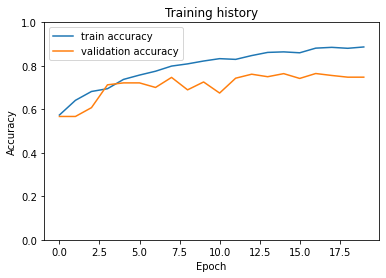

In [40]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [61]:
y_pred_lstm= model.predict_classes(X_val)

In [62]:
from sklearn.metrics import accuracy_score

In [63]:
accuracy_lstm= accuracy_score(y_pred_lstm,y_val)

In [64]:
print("The accuracy for the Lstm model is {} %".format(accuracy_lstm*100))

The accuracy for the Lstm model is 74.68487394957984 %


# Bidirectional LSTM
Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.

In problems where all timesteps of the input sequence are available, Bidirectional LSTMs train two instead of one LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This can provide additional context to the network and result in faster and even fuller learning on the problem.

*  https://www.coursera.org/lecture/nlp-sequence-models/bidirectional-rnn-fyXnn
* https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/#:~:text=Bidirectional%20LSTMs%20are%20an%20extension,LSTMs%20on%20the%20input%20sequence.

In [65]:
model=Sequential()
model.add(e)
model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
model.add(BatchNormalization())
model.add(Dense(1, activation = "sigmoid"))
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
hist=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=20,batch_size=64,verbose=1)

Epoch 1/20
90/90 [==============================] - 35s 392ms/step - loss: 0.6576 - accuracy: 0.6278 - val_loss: 0.6540 - val_accuracy: 0.5977
Epoch 2/20
90/90 [==============================] - 33s 368ms/step - loss: 0.5813 - accuracy: 0.6952 - val_loss: 0.6268 - val_accuracy: 0.6628
Epoch 3/20
90/90 [==============================] - 36s 401ms/step - loss: 0.5512 - accuracy: 0.7257 - val_loss: 0.6116 - val_accuracy: 0.6618
Epoch 4/20
90/90 [==============================] - 36s 403ms/step - loss: 0.5312 - accuracy: 0.7413 - val_loss: 0.5914 - val_accuracy: 0.6849
Epoch 5/20
90/90 [==============================] - 36s 400ms/step - loss: 0.4982 - accuracy: 0.7597 - val_loss: 0.5596 - val_accuracy: 0.7132
Epoch 6/20
90/90 [==============================] - 35s 391ms/step - loss: 0.4645 - accuracy: 0.7821 - val_loss: 0.5654 - val_accuracy: 0.7190
Epoch 7/20
90/90 [==============================] - 34s 378ms/step - loss: 0.4447 - accuracy: 0.7958 - val_loss: 0.5875 - val_accuracy: 0.7311

In [67]:
y_pred_bilstm= model.predict_classes(X_val)

In [68]:
accuracy_bilstm= accuracy_score(y_pred_bilstm,y_val)

In [69]:
print("The accuracy for the Bidirectional Lstm model is {} %".format(accuracy_bilstm*100))

The accuracy for the Bidirectional Lstm model is 73.16176470588235 %


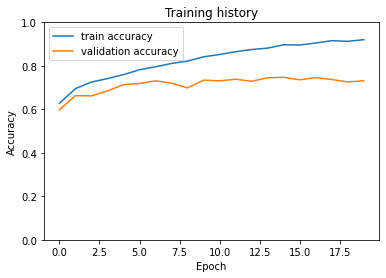

In [70]:
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# GRUs

To solve the vanishing gradient problem of a standard RNN, GRU uses, so-called, update gate and reset gate. Basically, these are two vectors which decide what information should be passed to the output. The special thing about them is that they can be trained to keep information from long ago, without washing it through time or remove information which is irrelevant to the prediction.

* https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be
* https://www.youtube.com/watch?v=8HyCNIVRbSU

In [71]:
model=Sequential()
model.add(e)
model.add(SpatialDropout1D(0.3))
model.add(GRU(100))
model.add(Dense(1, activation = "sigmoid"))
model.compile(optimizer='adam' ,loss='binary_crossentropy', metrics=['accuracy'])

In [72]:
hist=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=20,batch_size=64,verbose=1)

Epoch 1/20
90/90 [==============================] - 1s 12ms/step - loss: 0.6827 - accuracy: 0.5745 - val_loss: 0.6873 - val_accuracy: 0.5567
Epoch 2/20
90/90 [==============================] - 1s 7ms/step - loss: 0.6825 - accuracy: 0.5749 - val_loss: 0.6870 - val_accuracy: 0.5567
Epoch 3/20
90/90 [==============================] - 1s 7ms/step - loss: 0.6821 - accuracy: 0.5749 - val_loss: 0.6879 - val_accuracy: 0.5567
Epoch 4/20
90/90 [==============================] - 1s 7ms/step - loss: 0.6823 - accuracy: 0.5749 - val_loss: 0.6867 - val_accuracy: 0.5567
Epoch 5/20
90/90 [==============================] - 1s 7ms/step - loss: 0.6824 - accuracy: 0.5749 - val_loss: 0.6876 - val_accuracy: 0.5567
Epoch 6/20
90/90 [==============================] - 1s 7ms/step - loss: 0.6826 - accuracy: 0.5749 - val_loss: 0.6868 - val_accuracy: 0.5567
Epoch 7/20
90/90 [==============================] - 1s 7ms/step - loss: 0.6824 - accuracy: 0.5749 - val_loss: 0.6870 - val_accuracy: 0.5567
Epoch 8/20
90/90 [=

In [73]:
y_pred_gru= model.predict_classes(X_val)

In [74]:
accuracy_gru= accuracy_score(y_pred_gru,y_val)

In [75]:
print("The accuracy for the GRU model is {} %".format(accuracy_gru*100))

The accuracy for the GRU model is 71.21848739495799 %


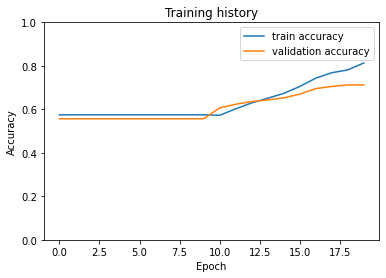

In [76]:
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Attention Model
attention in deep can be learning broadly interpreted as vector of importance weights, in order to predict ofinfer one element  such as pixel in an image or  a word in a sentence , we estimate using the attention  vector how stronglyit is correlating  witn other elements and take the sum of their  values aweighted by attention vector as the key approximation of the target

https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html

In [77]:
from keras.layers import Layer
import keras.backend as K

In [78]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [79]:
inputs=keras.Input(shape=(max_length,))
x=(e)(inputs)
att_in=LSTM(100,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(x)
att_out=attention()(att_in)
outputs=Dense(1,activation='sigmoid',trainable=True)(att_out)
modelA=Model(inputs,outputs)
modelA.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        multiple                  3366800   
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 100)           120400    
_________________________________________________________________
attention_1 (attention)      (None, 100)               150       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 3,487,451
Trainable params: 120,651
Non-trainable params: 3,366,800
_________________________________________________________________


In [80]:
modelA.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [81]:
hist=modelA.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=20,batch_size=64,verbose=1)

Epoch 1/20
90/90 [==============================] - 19s 207ms/step - loss: 0.6593 - accuracy: 0.6069 - val_loss: 0.6192 - val_accuracy: 0.6723
Epoch 2/20
90/90 [==============================] - 19s 208ms/step - loss: 0.6247 - accuracy: 0.6516 - val_loss: 0.5878 - val_accuracy: 0.6880
Epoch 3/20
90/90 [==============================] - 18s 204ms/step - loss: 0.5813 - accuracy: 0.6998 - val_loss: 0.5817 - val_accuracy: 0.6954
Epoch 4/20
90/90 [==============================] - 18s 203ms/step - loss: 0.5646 - accuracy: 0.7120 - val_loss: 0.5732 - val_accuracy: 0.7201
Epoch 5/20
90/90 [==============================] - 19s 211ms/step - loss: 0.5335 - accuracy: 0.7355 - val_loss: 0.5498 - val_accuracy: 0.7258
Epoch 6/20
90/90 [==============================] - 18s 197ms/step - loss: 0.5026 - accuracy: 0.7553 - val_loss: 0.5382 - val_accuracy: 0.7337
Epoch 7/20
90/90 [==============================] - 18s 197ms/step - loss: 0.4740 - accuracy: 0.7798 - val_loss: 0.5450 - val_accuracy: 0.7258

In [82]:
y_pred_attention= modelA.predict(X_val)

In [83]:

for i in range(len(y_pred_attention)):
    if (y_pred_attention[i]>=0.5):
        y_pred_attention[i]=1
    else:
        y_pred_attention[i]=0

In [84]:
from sklearn.metrics import accuracy_score

In [85]:
accuracy_attention= accuracy_score(y_pred_attention,y_val)

In [86]:
print("The accuracy for the attention model is {} %".format(accuracy_attention*100))

The accuracy for the attention model is 74.3172268907563 %


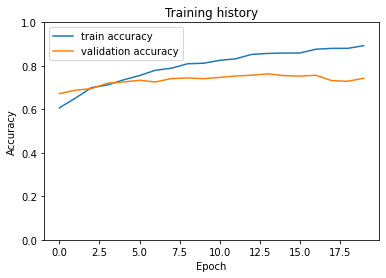

In [87]:
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [88]:
accuracy_score= {'accuracy_lstm':accuracy_lstm,'accuracy_bilstm':accuracy_bilstm,'accuracy_gru':accuracy_gru,'accuracy_attention':accuracy_attention}

**Comparing Accuracies**

In [89]:
accuracy_score

{'accuracy_lstm': 0.7468487394957983,
 'accuracy_bilstm': 0.7316176470588235,
 'accuracy_gru': 0.7121848739495799,
 'accuracy_attention': 0.743172268907563}

# Transformers:-
The Transformer – a model that uses attention to boost the speed with which these models can be trained
The Transformer was proposed in the paper Attention is All You Need.
A TensorFlow implementation of it is available as a part of the Tensor2Tensor package. Harvard’s NLP group created a guide annotating the paper with PyTorch implementation. 
**The Transformer in NLP is a novel architecture that aims to solve sequence-to-sequence tasks while handling long-range dependencies with ease**

* https://www.analyticsvidhya.com/blog/2019/06/understanding-transformers-nlp-state-of-the-art-models/
* http://jalammar.github.io/illustrated-transformer/
* https://medium.com/inside-machine-learning/what-is-a-transformer-d07dd1fbec04

In [28]:
import torch
import torch.nn as nn

In [29]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [30]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# BERT Transformer
*BERT stands for Bidirectional Encoder Representations from Transformers. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. *

Please head to my notebook
https://www.kaggle.com/alankritamishra/covid-19-tweet-sentiment-analysis
In this notebook I've thouroughly explained the working and understanding of BERT

In [24]:
PRE_TRAINED_MODEL_NAME = '../input/bert-base-uncased'

In [25]:
sample_txt = 'These are tough times we must stand together'


In [31]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [32]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: These are tough times we must stand together
   Tokens: ['these', 'are', 'tough', 'times', 'we', 'must', 'stand', 'together']
Token IDs: [2122, 2024, 7823, 2335, 2057, 2442, 3233, 2362]


In [33]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [34]:
token_lens = []
for txt in data.text:
    
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 0, 'Token count')

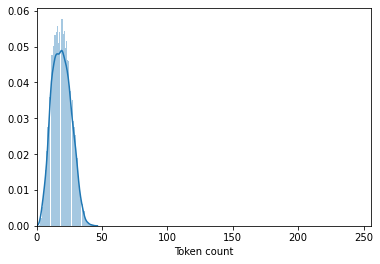

In [36]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [37]:
MAX_LEN=50

Creating Dataset

In [38]:
class DisasterTweet(Dataset):
    
    def __init__(self, tweets, label, tokenizer, max_len):
        
        
        self.tweets = tweets
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.tweets)
    def __getitem__(self, item):
        
        tweets = str(self.tweets[item])
        label = self.label[item]
        encoding = self.tokenizer.encode_plus(
        tweets,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt')
        return {
        'tweet_text': tweets,
         'input_ids': encoding['input_ids'].flatten(),
         'attention_mask': encoding['attention_mask'].flatten(),
         'labels': torch.tensor(label, dtype=torch.long)
          }    

In [39]:
train= list(zip(train['text'],label))

In [40]:
df = pd.DataFrame(train, columns = ['tweets', 'label'])

In [41]:
df.head()

,tweets,label
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,people receive wildfires evacuation orders in...,1
4,just got sent this photo from ruby alaska as s...,1


In [42]:
from sklearn.model_selection import train_test_split

In [43]:
train, val = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)

In [44]:
def create_data_loader(data, tokenizer, max_len, batch_size):
    
    ds = DisasterTweet(tweets=data.tweets.to_numpy(),
    label=data.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4)
BATCH_SIZE = 32
train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val, tokenizer, MAX_LEN, BATCH_SIZE)

In [45]:
train.shape,val.shape

((6851, 2), (762, 2))

In [46]:
df = next(iter(train_data_loader))
df.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'labels'])

In [47]:
print(df['input_ids'].shape)
print(df['attention_mask'].shape)
print(df['labels'].shape)


torch.Size([32, 50])
torch.Size([32, 50])
torch.Size([32])


In [48]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [49]:
class FakeNewsClassifier(nn.Module):
    
    def __init__(self, n_classes):
        
        super(FakeNewsClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        
        _, pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
        output = self.drop(pooled_output)
        return self.out(output)

In [50]:
n_classes= 2

In [51]:
#setting device to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [52]:
model = FakeNewsClassifier(n_classes)
model = model.to(device)

In [53]:
input_ids = df['input_ids'].to(device)
attention_mask = df['attention_mask'].to(device)

In [54]:
import torch.nn.functional as F

In [55]:
F.softmax(model(input_ids, attention_mask),dim=1)

tensor([[0.5246, 0.4754],
        [0.6198, 0.3802],
        [0.4389, 0.5611],
        [0.5819, 0.4181],
        [0.5039, 0.4961],
        [0.5747, 0.4253],
        [0.6139, 0.3861],
        [0.5845, 0.4155],
        [0.7053, 0.2947],
        [0.5243, 0.4757],
        [0.5472, 0.4528],
        [0.6432, 0.3568],
        [0.4796, 0.5204],
        [0.5849, 0.4151],
        [0.4924, 0.5076],
        [0.6700, 0.3300],
        [0.5637, 0.4363],
        [0.5994, 0.4006],
        [0.5830, 0.4170],
        [0.5995, 0.4005],
        [0.5673, 0.4327],
        [0.4372, 0.5628],
        [0.5805, 0.4195],
        [0.5808, 0.4192],
        [0.5618, 0.4382],
        [0.4224, 0.5776],
        [0.4409, 0.5591],
        [0.6199, 0.3801],
        [0.6492, 0.3508],
        [0.5336, 0.4664],
        [0.5848, 0.4152],
        [0.5040, 0.4960]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [56]:
model.parameters

<bound method Module.parameters of FakeNewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

In [57]:
EPOCHS = 20
optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [58]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler, n_examples):  
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)
        outputs = model(input_ids=input_ids,attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [59]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)
            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
        return correct_predictions.double() / n_examples, np.mean(losses)

In [60]:
from collections import defaultdict

In [61]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(model,train_data_loader,loss_fn,optimizer,device,scheduler,len(train))
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(model,val_data_loader,loss_fn,device,len(val))
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/20
----------
Train loss 0.48644461971382763 accuracy 0.7955043059407385
Val   loss 0.4188823016981284 accuracy 0.8097112860892388

Epoch 2/20
----------
Train loss 0.35181320150231205 accuracy 0.8641074295723251
Val   loss 0.482987355440855 accuracy 0.8031496062992126

Epoch 3/20
----------
Train loss 0.2720249275481978 accuracy 0.9059991242154429
Val   loss 0.6039291881024837 accuracy 0.7860892388451444

Epoch 4/20
----------
Train loss 0.22172046990761923 accuracy 0.9330024813895781
Val   loss 0.7293594405055046 accuracy 0.7874015748031495

Epoch 5/20
----------
Train loss 0.17889569536891095 accuracy 0.9465771420230623
Val   loss 0.7771766527245442 accuracy 0.7952755905511811

Epoch 6/20
----------
Train loss 0.16117506689976815 accuracy 0.9538753466647204
Val   loss 0.8502344768494368 accuracy 0.7900262467191601

Epoch 7/20
----------
Train loss 0.14669115786808867 accuracy 0.9578163771712158
Val   loss 0.9236237152169148 accuracy 0.7769028871391076

Epoch 8/20
----------


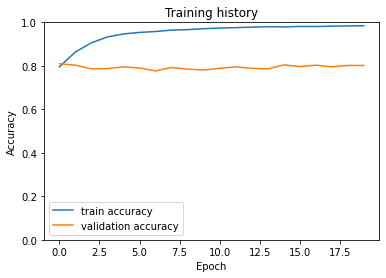

In [62]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Predicting on a random sentence

In [63]:
best_accuracy

tensor(0.8097, device='cuda:0', dtype=torch.float64)

We get 81% accuracy which is pretty good.

If you are unable to understand any code implementation
check out 
* https://www.kaggle.com/alankritamishra/covid-19-tweet-sentiment-analysis#What-is-BERT?
* https://towardsml.com/2019/09/17/bert-explained-a-complete-guide-with-theory-and-tutorial/
* https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

# The End
**If you liked my notebook Please show your support by upvoting it, It keeps me motivated to create more notebooks like this**

And please share any improvements and feedback